In [ ]:
#pre-imports for now
#from google.colab import files
#Uploaded = files.upload()
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute       import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


=== Preview: first 10 rows ===


,acq_channel,app_behavioral_score,requested_credit_limit,app_channel,credit_bureau_score,stated_income,is_customer,card_type
0,Partner3,1.808232,350,web,309,15000,True,prepaid_card
1,Partner2,4.382568,500,mobile,418,23000,True,prepaid_card
2,Partner2,-0.787575,400,web,507,24000,False,upmarket_card
3,Partner3,-2.131770,300,mobile,324,38000,False,upmarket_card
4,Partner3,-1.362938,450,mobile,736,38000,True,upmarket_card
5,Partner1,-2.558481,450,web,338,33000,True,highstreet_card
6,Organic,2.056254,550,web,745,20000,False,prepaid_card
7,Organic,0.345144,350,store,330,29000,False,upmarket_card
8,Partner4,1.026125,700,web,608,18000,False,prepaid_card
9,Organic,3.559346,650,mobile,714,18000,False,highstreet_card



=== Dataset dimensions ===
Rows: 60000, Columns: 8

=== Column data types ===
acq_channel                object
app_behavioral_score      float64
requested_credit_limit      int64
app_channel                object
credit_bureau_score         int64
stated_income               int64
is_customer                  bool
card_type                  object
dtype: object

=== Non-null counts ===
acq_channel               0
app_behavioral_score      0
requested_credit_limit    0
app_channel               0
credit_bureau_score       0
stated_income             0
is_customer               0
card_type                 0
dtype: int64

=== Descriptive statistics (numeric) ===


,count,mean,std,min,25%,50%,75%,max
app_behavioral_score,60000.0,-0.004771,1.992763,-7.707172,-1.350186,-0.005271,1.348051,9.793673
requested_credit_limit,60000.0,524.775000,155.993125,300.000000,400.000000,500.000000,650.000000,750.000000
credit_bureau_score,60000.0,549.495650,157.133692,300.000000,402.000000,550.000000,698.000000,799.000000
stated_income,60000.0,26965.883333,7841.773457,15000.000000,20000.000000,27000.000000,34000.000000,39000.000000



=== acq_channel ===
             count  percent
acq_channel                
Partner4     12616    21.03
Organic      12475    20.79
Partner1     11707    19.51
Partner3     11706    19.51
Partner2     11496    19.16

=== app_channel ===
             count  percent
app_channel                
mobile       24432    40.72
web          22516    37.53
store        13052    21.75

=== is_customer ===
             count  percent
is_customer                
False        35698     59.5
True         24302     40.5

=== card_type ===
                 count  percent
card_type                      
prepaid_card     20103    33.51
highstreet_card  19961    33.27
upmarket_card    19936    33.23


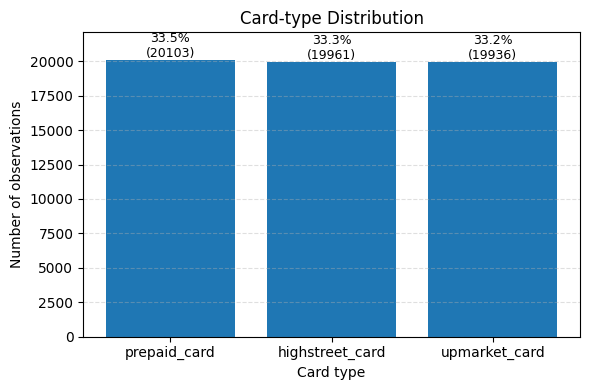


=== Missing percentage by column ===
acq_channel               0.0
app_behavioral_score      0.0
requested_credit_limit    0.0
app_channel               0.0
credit_bureau_score       0.0
stated_income             0.0
is_customer               0.0
card_type                 0.0
dtype: float64


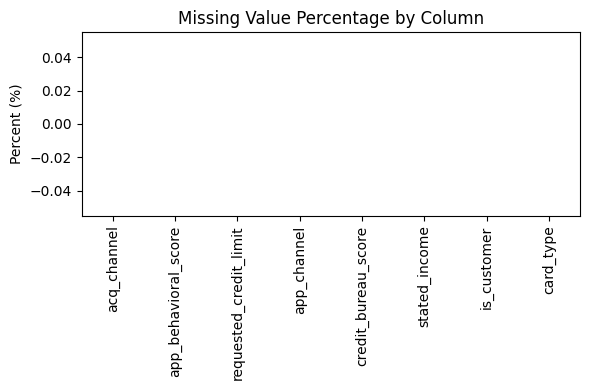

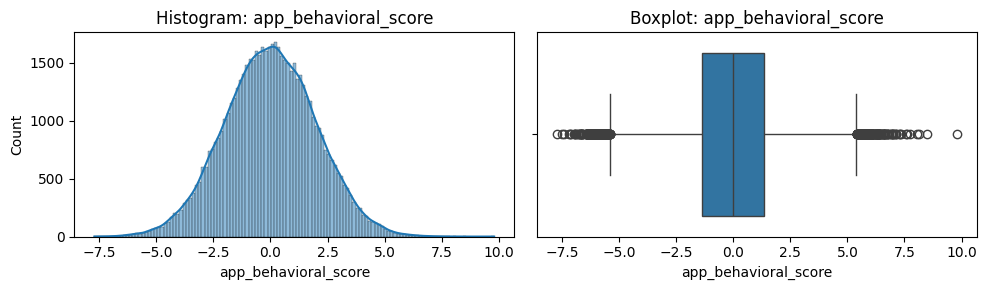

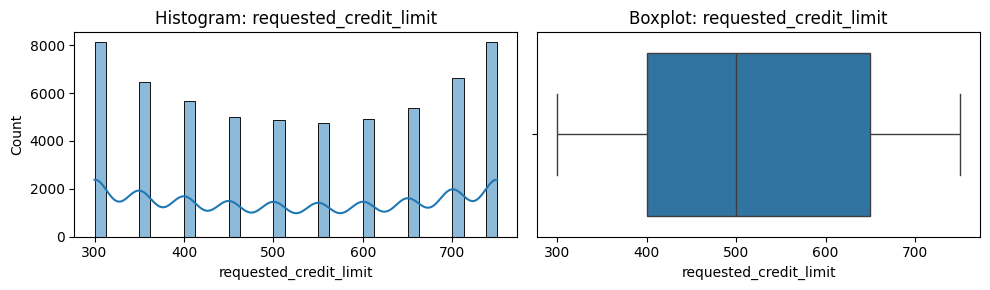

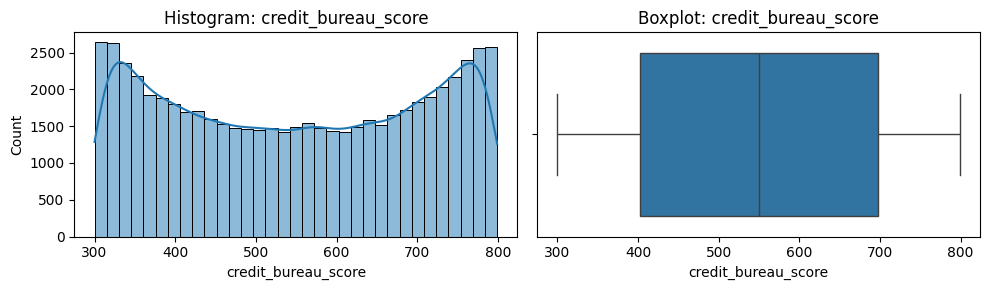

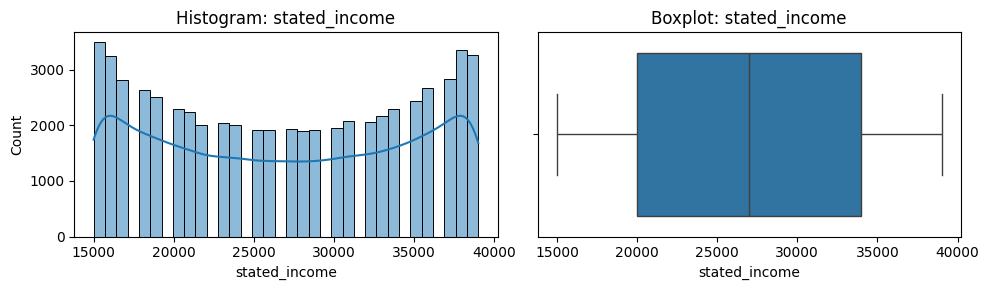


=== Outlier counts (IQR method) ===

-- k = 1.5 --
app_behavioral_score     :  386 outliers
requested_credit_limit   :    0 outliers
credit_bureau_score      :    0 outliers
stated_income            :    0 outliers

-- k = 3 --
app_behavioral_score     :    1 outliers
requested_credit_limit   :    0 outliers
credit_bureau_score      :    0 outliers
stated_income            :    0 outliers


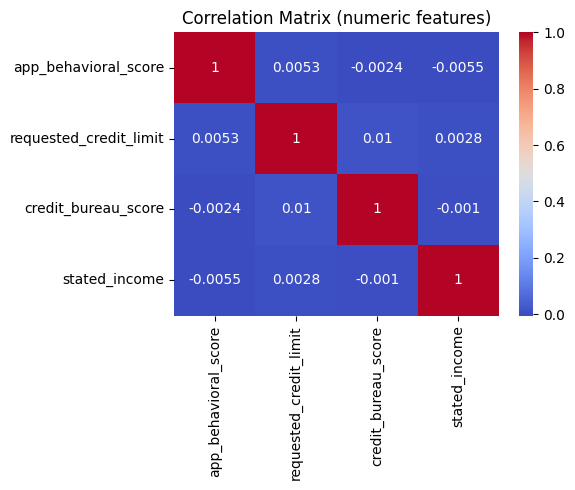

In [ ]:
# Exploratory Data Analysis (Part 1)
# ----------------------------------
# This section provides a thorough inspection of the raw dataset (`data_ori`)
# WITHOUT altering it in any way. All feature engineering is performed later
# on a deep copy of the original DataFrame.

# 1 | Load the data
# ---------------------------------------------------------------------------
DATA_PATH = 'Predict_Cardtype.csv'
# Changed the import to my folder, change accordingly - Ivan
data_ori  = pd.read_csv('/Users/ivanmiraglia/Desktop/Data Analytics Machine Learning/GroupProjects_Data/Predict_Cardtype.csv')

# 2 | Structural Overview
# ---------------------------------------------------------------------------
print("=== Preview: first 10 rows ===")
display(data_ori.head(10))

print("\n=== Dataset dimensions ===")
print(f"Rows: {data_ori.shape[0]}, Columns: {data_ori.shape[1]}")

print("\n=== Column data types ===")
print(data_ori.dtypes)

print("\n=== Non-null counts ===")
print(data_ori.isna().sum())

# 3 | Descriptive statistics
# ---------------------------------------------------------------------------
print("\n=== Descriptive statistics (numeric) ===")
display(data_ori.describe().T)

# 4 | Categorical profiling
# ---------------------------------------------------------------------------
cat_cols = ["acq_channel", "app_channel", "is_customer", "card_type"]

for col in cat_cols:
    counts   = data_ori[col].value_counts(dropna=False)
    percent  = counts / len(data_ori) * 100

    summary  = pd.DataFrame({
        "count":   counts,
        "percent": percent.round(2)         # round to 2 decimals
    })

    print(f"\n=== {col} ===")
    print(summary)

# 5 Visualise class balance of the target variable (card_type)
# ---------------------------------------------------------------------------

# Counts and percentages
card_counts   = data_ori["card_type"].value_counts()
card_percent  = card_counts / card_counts.sum() * 100

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(card_counts.index, card_counts.values)

# Annotations: "<pct>%\n(count)"
for bar, pct, cnt in zip(bars, card_percent, card_counts):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,            # slight offset above the bar - Joe
        f"{pct:.1f}%\n({cnt})",
        ha="center", va="bottom", fontsize=9
    )

# Aesthetics
ax.set_title("Card-type Distribution")
ax.set_ylabel("Number of observations")
ax.set_xlabel("Card type")
ax.set_ylim(0, card_counts.max() * 1.10)   # 10 % headroom for labels - Joe
ax.yaxis.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# 6 Missing-value audit
# ---------------------------------------------------------------------------
missing_pct = data_ori.isna().mean().sort_values(ascending=False) * 100
print("\n=== Missing percentage by column ===")
print(missing_pct)

plt.figure(figsize=(6,4))
missing_pct.plot(kind="bar")
plt.title("Missing Value Percentage by Column")
plt.ylabel("Percent (%)")
plt.tight_layout()
plt.show()

# 7 Distribution & outlier analysis (numeric features)
# ---------------------------------------------------------------------------
num_cols = [
    "app_behavioral_score",
    "requested_credit_limit",
    "credit_bureau_score",
    "stated_income"
]

# Histogram + boxplot loop - Kevin
for col in num_cols:
    fig, ax = plt.subplots(1, 2, figsize=(10,3))
    sns.histplot(data_ori[col], kde=True, ax=ax[0])
    ax[0].set_title(f"Histogram: {col}")
    sns.boxplot(x=data_ori[col], ax=ax[1])
    ax[1].set_title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()

# IQR outlier counts (k = 1.5 and 3) and extreme value lists
print("\n=== Outlier counts (IQR method) ===")
for k in [1.5, 3]:
    print(f"\n-- k = {k} --")
    for col in num_cols:
        q1, q3 = data_ori[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - k * iqr, q3 + k * iqr
        mask  = (data_ori[col] < lower) | (data_ori[col] > upper)
        count = mask.sum()
        print(f"{col:25s}: {count:4d} outliers")

# 8 Correlation analysis (numerical features)
# ---------------------------------------------------------------------------
plt.figure(figsize=(6,5))
sns.heatmap(data_ori[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (numeric features)")
plt.tight_layout()
plt.show()

In [ ]:
###############################################################################
# Feature Exploration, Engineering & Data-Frame Preparation (Part 2)
# ------------------------------------------------------------------
# All transformations are performed on a deep copy of the original data.
###############################################################################

# 0 Create a working copy
# ---------------------------------------------------------------------------
df = data_ori.copy(deep=True)

# 1 Explicit type casting
# ---------------------------------------------------------------------------
df["is_customer"] = df["is_customer"].astype("boolean") #Check if this is needed
df["card_type"]   = df["card_type"].astype("object")

# 2 Imputation
# ---------------------------------------------------------------------------
# Numeric – median; categorical – mode
num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

for col in cat_cols[:-1]:   # exclude target ('card_type')
    df[col] = df[col].fillna(df[col].mode()[0])


print("\nMissing values after imputation:")
print(df.isna().sum())

# 3 Outlier capping (IQR, k = 1.5)
# ---------------------------------------------------------------------------
for col in num_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    df[col] = df[col].clip(lower, upper)

# 4 One-hot encode categorical predictors
# ---------------------------------------------------------------------------
predictor_cats = ["acq_channel", "app_channel", "is_customer"]
df_enc = pd.get_dummies(df, columns=predictor_cats, drop_first=True)
print("\nOne-hot encoding complete. New shape:", df_enc.shape)

# 5 Train / test split (stratified by target)
# ---------------------------------------------------------------------------
X = df_enc.drop("card_type", axis=1)
y = df_enc["card_type"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

print("\nTrain-test split complete:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

# 6 Scale numeric features
# ---------------------------------------------------------------------------
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])
print("Numeric features scaled (zero mean, unit variance).")

# 7 Min-Max scaling on original data_ori for other experiments
# ---------------------------------------------------------------------------
# Note: does NOT affect df, X_train, or X_test
mms = MinMaxScaler()
data_ori_scaled = data_ori.copy()
data_ori_scaled[num_cols] = mms.fit_transform(data_ori_scaled[num_cols])

# 8 Ready for modeling!!!!!! :DDD
# ---------------------------------------------------------------------------
print("\nData-preparation pipeline complete — ready for model building!")


Missing values after imputation:
acq_channel               0
app_behavioral_score      0
requested_credit_limit    0
app_channel               0
credit_bureau_score       0
stated_income             0
is_customer               0
card_type                 0
dtype: int64

One-hot encoding complete. New shape: (60000, 12)

Train-test split complete:
X_train: (42000, 11), X_test: (18000, 11)
Numeric features scaled (zero mean, unit variance).

Data-preparation pipeline complete — ready for model building!


In [ ]:
###############################################################################
# 3 Train-Test Splitting & Scaling
# ----------------------------------
# This step separates predictors from the target, performs a stratified split
# (preserving class balance) and applies standardization to numeric features.
###############################################################################

# 1 Split into features and target
# ---------------------------------------------------------------------------
X = df_enc.drop("card_type", axis=1)
y = df_enc["card_type"]

# 2 Stratified train-test split
# ---------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,         # 70% train, 30% test
    stratify=y,             # ensures proportional card_type representation
    random_state=42         # reproducibility
)

print("\nTrain-test split complete:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train distribution:\n{y_train.value_counts(normalize=True).round(3)}")

# 3 Standardize numeric features (zero mean, unit variance)
# ---------------------------------------------------------------------------
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

print("Numeric features scaled (standardization complete).")



Train-test split complete:
X_train: (42000, 11), X_test: (18000, 11)
y_train distribution:
card_type
prepaid_card       0.335
highstreet_card    0.333
upmarket_card      0.332
Name: proportion, dtype: float64
Numeric features scaled (standardization complete).



[Baseline LogReg] CV F1_macro: 0.7674 ± 0.0075
[Baseline LogReg] Test F1_macro: 0.7626

Classification Report (Test Set):
                 precision    recall  f1-score   support

highstreet_card     0.7511    0.7575    0.7543      5988
   prepaid_card     0.7688    0.7629    0.7658      6031
  upmarket_card     0.7679    0.7673    0.7676      5981

       accuracy                         0.7626     18000
      macro avg     0.7626    0.7626    0.7626     18000
   weighted avg     0.7626    0.7626    0.7626     18000



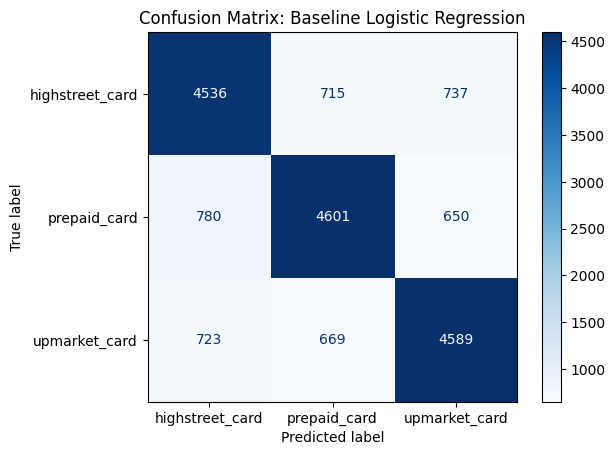

In [ ]:
# ---------------------------------------------------------------------------
# Part 4 / Set up, Train and Test Log Reg Model as Benchmark (No Tuning)
# ---------------------------------------------------------------------------

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score
)
import matplotlib.pyplot as plt
import numpy as np

# 1 Define Stratified CV object
# ---------------------------------------------------------------------------

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 2 Train baseline Logistic Regression model
# ---------------------------------------------------------------------------

baseline_logreg = LogisticRegression(
    penalty='l2',         # default
    C=1.0,                # default
    solver='lbfgs',       # default for multi-class
    max_iter=1000,
    random_state=42
)
baseline_logreg.fit(X_train, y_train)

# 3 Cross validation on training set
# ---------------------------------------------------------------------------

cv_scores = cross_val_score(baseline_logreg, X_train, y_train, cv=cv, scoring='f1_macro')

# 4 Predict and evaluate on test set
# ---------------------------------------------------------------------------

y_test_pred = baseline_logreg.predict(X_test)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')

# 5 Save to results dictionary (used later)
# ---------------------------------------------------------------------------
results = {}
results['Logistic Regression'] = [
    cv_scores.mean(),
    cv_scores.std(),
    test_f1_macro
]

# 6 Report results
# ---------------------------------------------------------------------------

print(f"\n[Baseline LogReg] CV F1_macro: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"[Baseline LogReg] Test F1_macro: {test_f1_macro:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, digits=4))

# 7 Plot confusion matrix
# ---------------------------------------------------------------------------

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Baseline Logistic Regression")
plt.grid(False)
plt.show()


In [ ]:
# ---------------------------------------------------------------------------
# Part Cinco / Setup All class Models, Train all class models and Test all class models
# ---------------------------------------------------------------------------


from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import pandas as pd

# 1 Stratified CV
# ---------------------------------------------------------------------------

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 2 Results dict
# ---------------------------------------------------------------------------

results = {}

# 3 Already computed Logistic Regression results 
# ---------------------------------------------------------------------------

# Log Reg (Baseline computed in last code block so just pulling the result)
results['Logistic Regression'] = [
    cv_scores.mean(),
    cv_scores.std(),
    test_f1_macro 
]

# 3.1 Ridge Classifier
# ---------------------------------------------------------------------------

ridge = RidgeClassifier()
ridge_scores = cross_val_score(ridge, X_train, y_train, cv=cv, scoring='f1_macro')
ridge.fit(X_train, y_train)
ridge_test_f1 = f1_score(y_test, ridge.predict(X_test), average='macro')
results['Ridge Classifier'] = [ridge_scores.mean(), ridge_scores.std(), ridge_test_f1]

# 3.2 k Nearest Neighbors
# ---------------------------------------------------------------------------

knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring='f1_macro')
knn.fit(X_train, y_train)
knn_test_f1 = f1_score(y_test, knn.predict(X_test), average='macro')
results['k-Nearest Neighbors'] = [knn_scores.mean(), knn_scores.std(), knn_test_f1]

# 3.3 Decision Tree
# ---------------------------------------------------------------------------

dt = DecisionTreeClassifier(random_state=42)
dt_scores = cross_val_score(dt, X_train, y_train, cv=cv, scoring='f1_macro')
dt.fit(X_train, y_train)
dt_test_f1 = f1_score(y_test, dt.predict(X_test), average='macro')
results['Decision Tree'] = [dt_scores.mean(), dt_scores.std(), dt_test_f1]

# 3.4 Random Forest
# ---------------------------------------------------------------------------

rf = RandomForestClassifier(random_state=42)
rf_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='f1_macro')
rf.fit(X_train, y_train)
rf_test_f1 = f1_score(y_test, rf.predict(X_test), average='macro')
results['Random Forest'] = [rf_scores.mean(), rf_scores.std(), rf_test_f1]

# 3.5 Neural Network (MLP)
# ---------------------------------------------------------------------------

mlp = MLPClassifier(max_iter=1000, random_state=42)
mlp_scores = cross_val_score(mlp, X_train, y_train, cv=cv, scoring='f1_macro')
mlp.fit(X_train, y_train)
mlp_test_f1 = f1_score(y_test, mlp.predict(X_test), average='macro')
results['Neural Network (MLP)'] = [mlp_scores.mean(), mlp_scores.std(), mlp_test_f1]

# 3.6 Support Vector Machine (SVM)
# ---------------------------------------------------------------------------

svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_scores = cross_val_score(svm, X_train, y_train, cv=cv, scoring='f1_macro')
svm.fit(X_train, y_train)
svm_test_f1 = f1_score(y_test, svm.predict(X_test), average='macro')
results['SVM'] = [svm_scores.mean(), svm_scores.std(), svm_test_f1]

# 4 Results DataFrame
# ---------------------------------------------------------------------------

results_df = pd.DataFrame.from_dict(
    results,
    orient='index',
    columns=['F1_macro_CV_mean', 'F1_macro_CV_std', 'F1_macro_Test']
).sort_values(by='F1_macro_CV_mean', ascending=False)

print("\nFull Benchmark Results (CV + Test):")
display(results_df.style.format({
    'F1_macro_CV_mean': "{:.4f}",
    'F1_macro_CV_std': "{:.4f}",
    'F1_macro_Test': "{:.4f}"
}))

# 5 Top 3 by CV!
# ---------------------------------------------------------------------------
top_3_df = results_df.head(3)

print("\nTop 3 Models (by CV F1_macro) for Further Tuning:")
display(top_3_df.style.format({
    'F1_macro_CV_mean': "{:.4f}",
    'F1_macro_CV_std': "{:.4f}",
    'F1_macro_Test': "{:.4f}"
}))



Full Benchmark Results (CV + Test):


,F1_macro_CV_mean,F1_macro_CV_std,F1_macro_Test
SVM,0.7724,0.0076,0.7645
Neural Network (MLP),0.7719,0.0091,0.7646
Logistic Regression,0.7674,0.0075,0.7626
Ridge Classifier,0.7653,0.0070,0.7619
Random Forest,0.7551,0.0083,0.7503
k-Nearest Neighbors,0.7303,0.0068,0.7294
Decision Tree,0.6689,0.0078,0.6692



Top 3 Models (by CV F1_macro) for Further Tuning:


,F1_macro_CV_mean,F1_macro_CV_std,F1_macro_Test
SVM,0.7724,0.0076,0.7645
Neural Network (MLP),0.7719,0.0091,0.7646
Logistic Regression,0.7674,0.0075,0.7626


Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best parameters: {'C': 1, 'gamma': 'scale'}
Best CV F1_macro: 0.7724
Test F1_macro: 0.7645


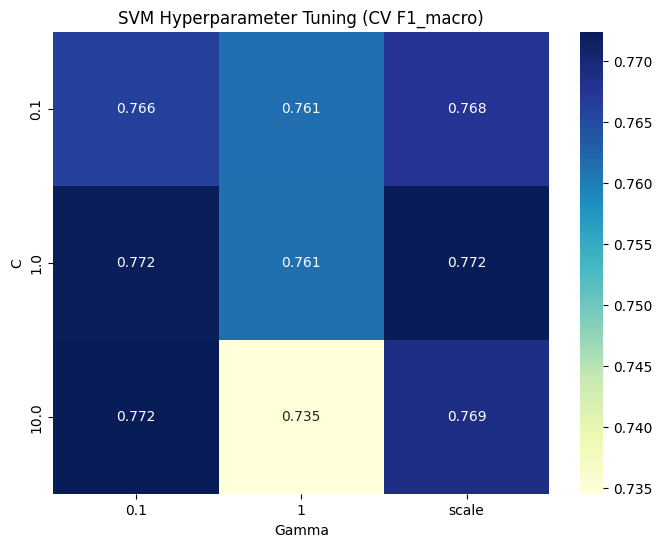

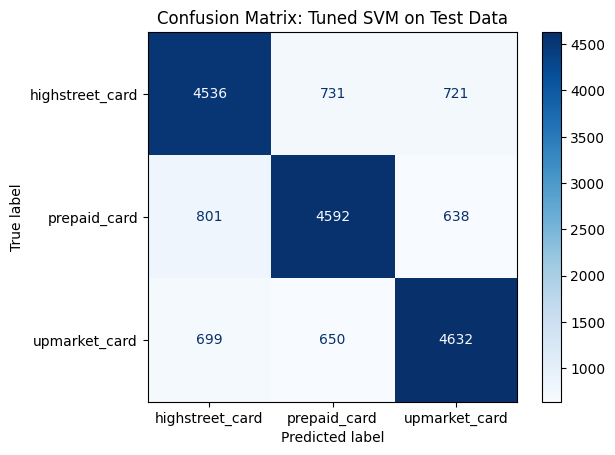

[learning_curve] Training set sizes: [ 3780  7560 11340 15120 18900 22680 26460 30240 34020 37800]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 19.3min finished


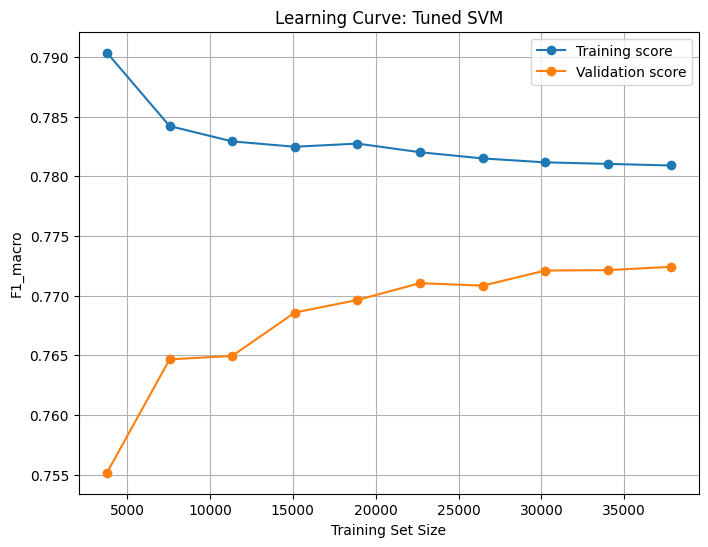

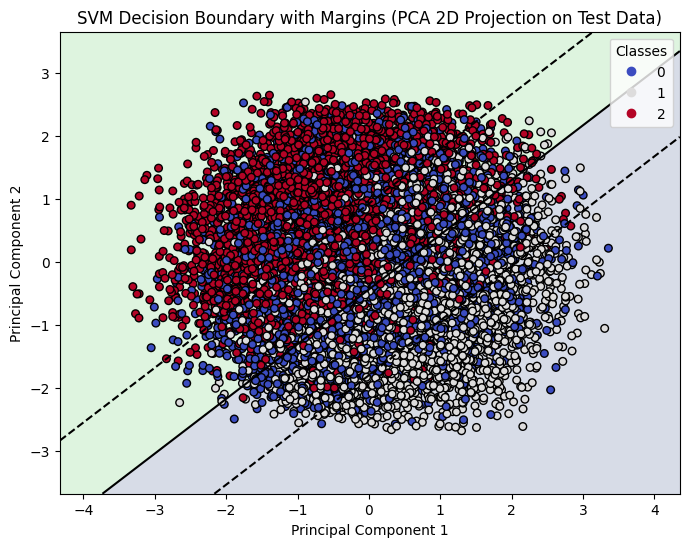

In [ ]:
# ---------------------------------------------------------------------------
# Part 6.1 / Re-Model top 3 Class Models and tune until optimal result found, Start with SVM
# ---------------------------------------------------------------------------


from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1 Define SVM parameter grid
# ---------------------------------------------------------------------------

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 'scale']
}

svm = SVC(kernel='rbf', probability=True, random_state=42)

# 1.1 GridSearchCV setup (on TRAINING DATA)
# ---------------------------------------------------------------------------

grid_search_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search_svm.fit(X_train, y_train)

print(f"Best parameters: {grid_search_svm.best_params_}")
print(f"Best CV F1_macro: {grid_search_svm.best_score_:.4f}")

# 1.2 Refit best model on all training data
# ---------------------------------------------------------------------------

best_svm = grid_search_svm.best_estimator_

# 1.3 Evaluate on TEST data
# ---------------------------------------------------------------------------

y_test_pred = best_svm.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f"Test F1_macro: {test_f1:.4f}")

# 1.4 Heatmap of GridSearchCV (from training CV results)
# ---------------------------------------------------------------------------

cv_results = pd.DataFrame(grid_search_svm.cv_results_)
heatmap_data = cv_results.pivot_table(
    index='param_C',
    columns='param_gamma',
    values='mean_test_score'
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("SVM Hyperparameter Tuning (CV F1_macro)")
plt.ylabel("C")
plt.xlabel("Gamma")
plt.show()

# 1.5 Confusion Matrix (on TEST data)
# ---------------------------------------------------------------------------

disp = ConfusionMatrixDisplay.from_estimator(
    best_svm,
    X_test,
    y_test,
    cmap="Blues",
    normalize=None
)
plt.title("Confusion Matrix: Tuned SVM on Test Data")
plt.grid(False)
plt.show()

# 1.6 Learning Curve (computed on TRAINING splits but plotted)
# ---------------------------------------------------------------------------

train_sizes, train_scores, val_scores = learning_curve(
    best_svm,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    verbose=1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training score", marker='o')
plt.plot(train_sizes, val_mean, label="Validation score", marker='o')
plt.title("Learning Curve: Tuned SVM")
plt.xlabel("Training Set Size")
plt.ylabel("F1_macro")
plt.legend()
plt.grid(True)
plt.show()

# 1.7 Decision Boundary (PCA projection of TEST data)
# ---------------------------------------------------------------------------

label_enc = LabelEncoder()
y_test_encoded = label_enc.fit_transform(y_test)

pca = PCA(n_components=2, random_state=42)
X_test_pca = pd.DataFrame(pca.fit_transform(X_test), columns=['PC1', 'PC2'])

svm_2d = SVC(kernel='linear', C=1, decision_function_shape='ovo', random_state=42)
svm_2d.fit(X_test_pca, y_test_encoded)

x_min, x_max = X_test_pca.iloc[:, 0].min() - 1, X_test_pca.iloc[:, 0].max() + 1
y_min, y_max = X_test_pca.iloc[:, 1].min() - 1, X_test_pca.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
X_mesh_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X_test_pca.columns)

Z = svm_2d.decision_function(X_mesh_df)
if Z.ndim > 1:  # multiclass
    Z = Z[:, 0]
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z > 0, alpha=0.2, levels=1)
plt.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k')

scatter = plt.scatter(X_test_pca.iloc[:, 0], X_test_pca.iloc[:, 1],
                      c=y_test_encoded, cmap=plt.cm.coolwarm, s=30, edgecolors='k')
plt.legend(*scatter.legend_elements(), title="Classes", loc='upper right')

plt.title("SVM Decision Boundary with Margins (PCA 2D Projection on Test Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(False)
plt.show()

# Save Results
# ---------------------------------------------------------------------------
svm_tuned_cv_mean = grid_search_svm.best_score_
svm_tuned_cv_std = np.std(grid_search_svm.cv_results_['mean_test_score'])
svm_tuned_test_f1 = f1_score(y_test, best_svm.predict(X_test), average='macro')


Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Best CV F1_macro (Train): 0.7740
Test F1_macro: 0.7661


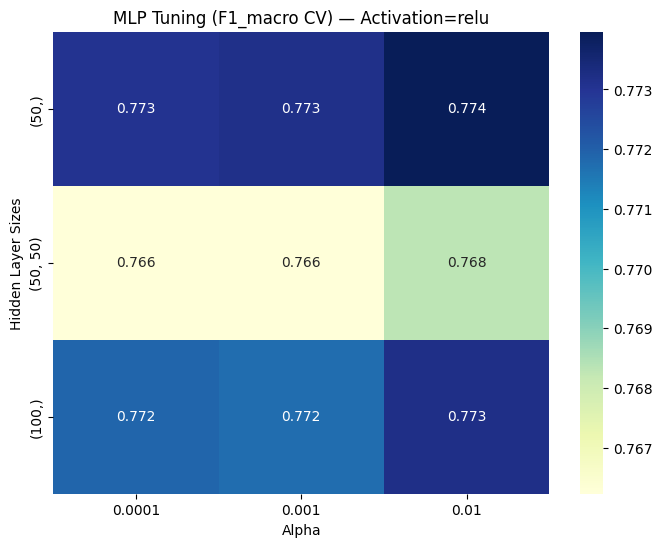

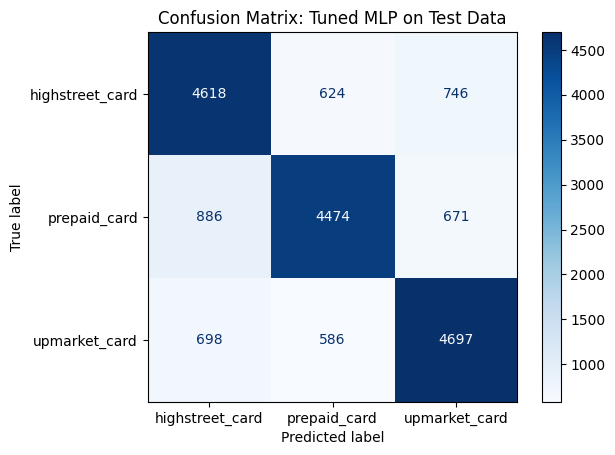

[learning_curve] Training set sizes: [ 3780  7560 11340 15120 18900 22680 26460 30240 34020 37800]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished


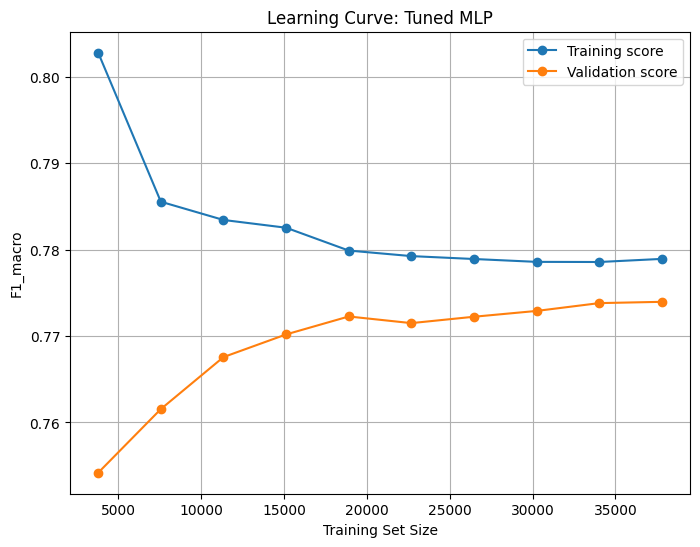

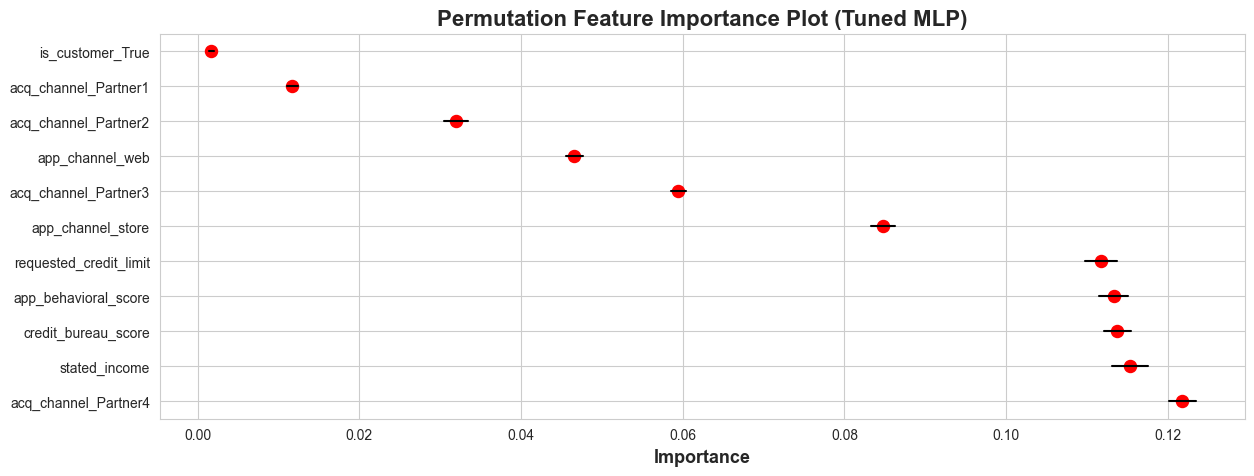

In [ ]:
# ---------------------------------------------------------------------------
# Part 6.2 / MLP Tuning
# ---------------------------------------------------------------------------


from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1 Define MLP parameter grid
# ---------------------------------------------------------------------------

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'activation': ['relu', 'tanh']
}

mlp = MLPClassifier(max_iter=2000, random_state=42)

# 2 Tune hyperparameters (TRAIN set only)
# ---------------------------------------------------------------------------

grid_search_mlp = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search_mlp.fit(X_train, y_train)

print(f"Best parameters: {grid_search_mlp.best_params_}")
print(f"Best CV F1_macro (Train): {grid_search_mlp.best_score_:.4f}")

# 3 Fit final model (TRAIN set with best params)
# ---------------------------------------------------------------------------

best_mlp = grid_search_mlp.best_estimator_
best_mlp.fit(X_train, y_train)

# 4 Test final model (TEST set)
# ---------------------------------------------------------------------------

y_test_pred = best_mlp.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f"Test F1_macro: {test_f1:.4f}")

# 5 Heatmap of CV results (TRAIN set CV)
# ---------------------------------------------------------------------------

cv_results = pd.DataFrame(grid_search_mlp.cv_results_)
best_activation = grid_search_mlp.best_params_['activation']
cv_best_act = cv_results[cv_results['param_activation'] == best_activation]

heatmap_data = cv_best_act.pivot_table(
    index='param_hidden_layer_sizes',
    columns='param_alpha',
    values='mean_test_score'
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title(f"MLP Tuning (F1_macro CV) — Activation={best_activation}")
plt.ylabel("Hidden Layer Sizes")
plt.xlabel("Alpha")
plt.show()

# 6 Confusion Matrix (TEST set)
# ---------------------------------------------------------------------------

disp = ConfusionMatrixDisplay.from_estimator(
    best_mlp,
    X_test,
    y_test,
    cmap="Blues",
    normalize=None
)
plt.title("Confusion Matrix: Tuned MLP on Test Data")
plt.grid(False)
plt.show()

# 7 Learning Curve (TRAIN set splits)
# ---------------------------------------------------------------------------

train_sizes, train_scores, val_scores = learning_curve(
    best_mlp,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    verbose=1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training score", marker='o')
plt.plot(train_sizes, val_mean, label="Validation score", marker='o')
plt.title("Learning Curve: Tuned MLP")
plt.xlabel("Training Set Size")
plt.ylabel("F1_macro")
plt.legend()
plt.grid(True)
plt.show()

# Save Results
# ---------------------------------------------------------------------------
mlp_tuned_cv_mean = grid_search_mlp.best_score_
mlp_tuned_cv_std = np.std(grid_search_mlp.cv_results_['mean_test_score'])
mlp_tuned_test_f1 = f1_score(y_test, best_mlp.predict(X_test), average='macro')


# 8 The following code will create a plot for permutation importance - Joe
# ---------------------------------------------------------------------------
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute permutation importance on TRAIN data
r = permutation_importance(
    best_mlp,
    X_train,
    y_train,
    scoring='f1_macro',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Prepare data for plot
features_names = []
importance = []
lower, upper = [], []

for i in r.importances_mean.argsort()[::-1]:
    features_names.append(X_train.columns[i])
    importance.append(r.importances_mean[i])
    lower.append(r.importances_mean[i] - r.importances_std[i])
    upper.append(r.importances_mean[i] + r.importances_std[i])

# Plot
with sns.axes_style("whitegrid"):
    yaxis = range(len(importance))
    plt.figure(figsize=(14, 5))
    plt.scatter(importance, yaxis, color='r', s=75)
    plt.plot((lower, upper), (yaxis, yaxis), 'k-')
    plt.yticks(yaxis, features_names)
    plt.xlabel('Importance', weight='bold', size=13)
    plt.title('Permutation Feature Importance Plot (Tuned MLP)', weight='bold', size=16)
    plt.show()


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters: {'C': 100, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV F1_macro (Train): 0.7676
Test F1_macro: 0.7628


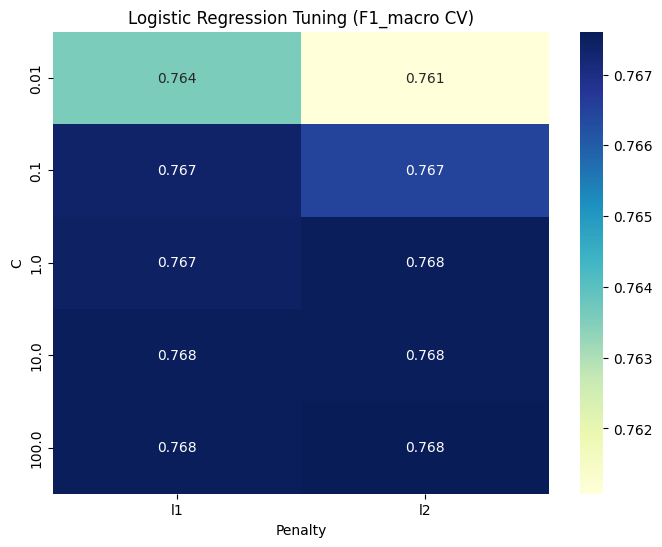

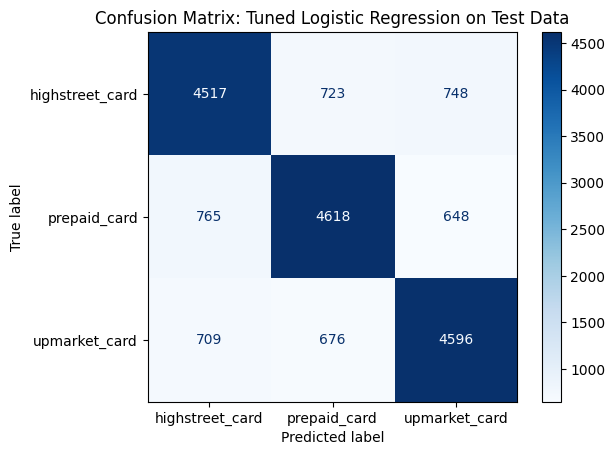

[learning_curve] Training set sizes: [ 3780  7560 11340 15120 18900 22680 26460 30240 34020 37800]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished


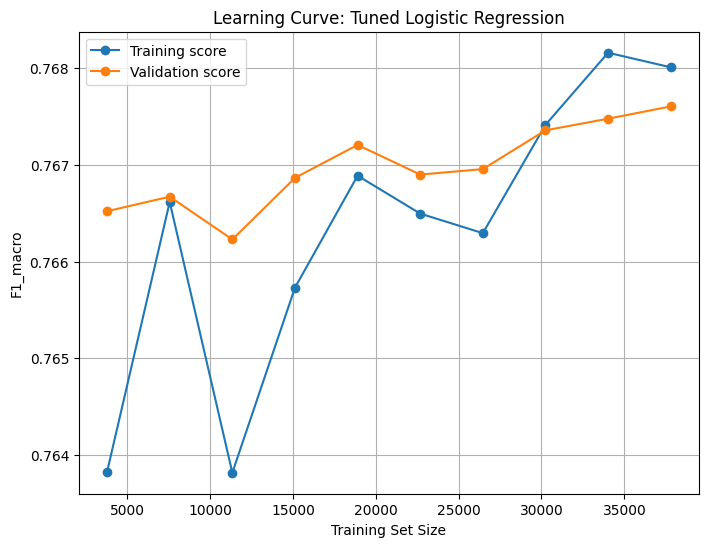

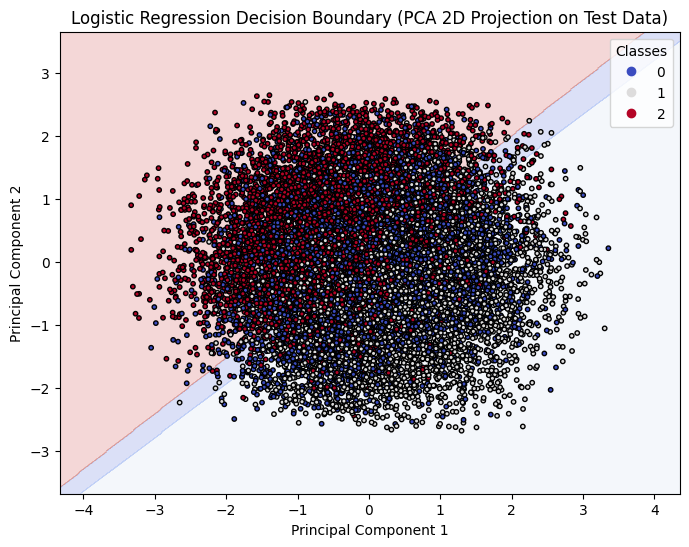

In [ ]:
# ---------------------------------------------------------------------------
# Part 6.3 / Log Reg Tuning
# ---------------------------------------------------------------------------


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1 Hyperparameter grid for Logistic Regression
# ---------------------------------------------------------------------------

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [1000]
}

logreg = LogisticRegression(random_state=42)

# 2 Tune hyperparameters (TRAIN set)
# ---------------------------------------------------------------------------

grid_search_logreg = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search_logreg.fit(X_train, y_train)

print(f"Best parameters: {grid_search_logreg.best_params_}")
print(f"Best CV F1_macro (Train): {grid_search_logreg.best_score_:.4f}")

# 3 Fit best model on TRAIN set
# ---------------------------------------------------------------------------

best_logreg = grid_search_logreg.best_estimator_
best_logreg.fit(X_train, y_train)

# 4 Evaluate on TEST set
# ---------------------------------------------------------------------------

y_test_pred = best_logreg.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f"Test F1_macro: {test_f1:.4f}")

# 5 Heatmap of CV results
# ---------------------------------------------------------------------------

cv_results = pd.DataFrame(grid_search_logreg.cv_results_)
heatmap_data = cv_results.pivot_table(
    index='param_C',
    columns='param_penalty',
    values='mean_test_score'
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Logistic Regression Tuning (F1_macro CV)")
plt.ylabel("C")
plt.xlabel("Penalty")
plt.show()

# 6 Confusion Matrix (TEST set)
# ---------------------------------------------------------------------------

disp = ConfusionMatrixDisplay.from_estimator(
    best_logreg,
    X_test,
    y_test,
    cmap="Blues",
    normalize=None
)
plt.title("Confusion Matrix: Tuned Logistic Regression on Test Data")
plt.grid(False)
plt.show()

# 7 Learning Curve (TRAIN splits)
# ---------------------------------------------------------------------------

train_sizes, train_scores, val_scores = learning_curve(
    best_logreg,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    verbose=1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training score", marker='o')
plt.plot(train_sizes, val_mean, label="Validation score", marker='o')
plt.title("Learning Curve: Tuned Logistic Regression")
plt.xlabel("Training Set Size")
plt.ylabel("F1_macro")
plt.legend()
plt.grid(True)
plt.show()

# 8 Decision Boundary (PCA projection of TEST set)
# ---------------------------------------------------------------------------

label_enc = LabelEncoder()
y_test_encoded = label_enc.fit_transform(y_test)

pca = PCA(n_components=2, random_state=42)
X_test_pca = pd.DataFrame(pca.fit_transform(X_test), columns=['PC1', 'PC2'])

logreg_2d = LogisticRegression(
    C=1, penalty='l2', solver='liblinear', max_iter=1000, random_state=42
)
logreg_2d.fit(X_test_pca, y_test_encoded)

x_min, x_max = X_test_pca.iloc[:, 0].min() - 1, X_test_pca.iloc[:, 0].max() + 1
y_min, y_max = X_test_pca.iloc[:, 1].min() - 1, X_test_pca.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
X_mesh_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X_test_pca.columns)

Z = logreg_2d.predict(X_mesh_df)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
scatter = plt.scatter(X_test_pca.iloc[:, 0], X_test_pca.iloc[:, 1],
                      c=y_test_encoded, cmap=plt.cm.coolwarm, s=10, edgecolors='k')
plt.legend(*scatter.legend_elements(), title="Classes", loc='upper right')
plt.title("Logistic Regression Decision Boundary (PCA 2D Projection on Test Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(False)
plt.show()

# Save Results
# ---------------------------------------------------------------------------
logreg_tuned_cv_mean = grid_search_logreg.best_score_
logreg_tuned_cv_std = np.std(grid_search_logreg.cv_results_['mean_test_score'])
logreg_tuned_test_f1 = f1_score(y_test, best_logreg.predict(X_test), average='macro')


[Stacking Model] CV F1_macro: 0.7709 ± 0.0022
[Stacking Model] Test F1_macro: 0.7654

                 precision    recall  f1-score   support

highstreet_card       0.74      0.77      0.76      5988
   prepaid_card       0.78      0.75      0.77      6031
  upmarket_card       0.77      0.78      0.77      5981

       accuracy                           0.77     18000
      macro avg       0.77      0.77      0.77     18000
   weighted avg       0.77      0.77      0.77     18000



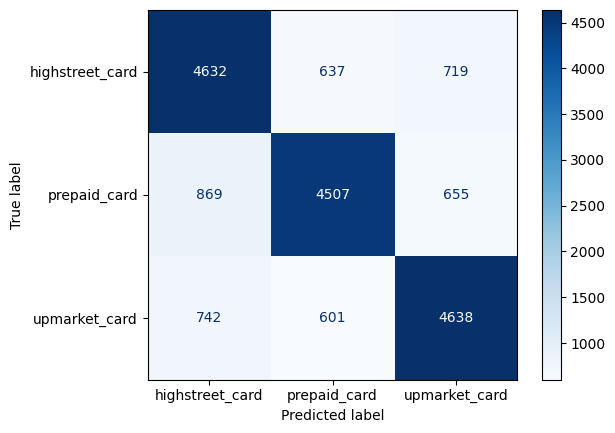

In [ ]:
# ---------------------------------------------------------------------------
# Part 7: STACKING CLASSIFIER
# ---------------------------------------------------------------------------

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay

# 1 Load the data
# ---------------------------------------------------------------------------
df = pd.read_csv('/Users/ivanmiraglia/Desktop/Data Analytics Machine Learning/GroupProjects_Data/Predict_Cardtype.csv')

# 2 Preprocessing
# ---------------------------------------------------------------------------
df["is_customer"] = df["is_customer"].astype(int)
df["card_type"] = df["card_type"].astype(str)

num_cols = ["app_behavioral_score", "requested_credit_limit", "credit_bureau_score", "stated_income"]
cat_cols = ["acq_channel", "app_channel", "is_customer"]

df_enc = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df_enc.drop("card_type", axis=1)
y = df_enc["card_type"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 3 Define base models (all scaled consistently)
# ---------------------------------------------------------------------------
svm_model = make_pipeline(
    StandardScaler(),
    SVC(C=1, gamma='scale', probability=True, random_state=42)
)

mlp_model = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=(50,),
        alpha=0.01,
        activation='relu',
        max_iter=2000,
        random_state=42
    )
)

logreg_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        solver='lbfgs',
        max_iter=2000,
        random_state=42
    )
)

# 4 Define stacking model (meta-model also scaled to improve convergence)
# ---------------------------------------------------------------------------
meta_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10000,
        solver='lbfgs',
        random_state=42
    )
)

stacking_model = StackingClassifier(
    estimators=[
        ('svm', svm_model),
        ('mlp', mlp_model),
        ('logreg', logreg_model)
    ],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# 5 Cross-validation on training set
# ---------------------------------------------------------------------------
cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
print(f"[Stacking Model] CV F1_macro: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 6 Final test evaluation
# ---------------------------------------------------------------------------
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)

test_f1 = f1_score(y_test, y_pred_stack, average='macro')
print(f"[Stacking Model] Test F1_macro: {test_f1:.4f}\n")

print(classification_report(y_test, y_pred_stack))

# 7 Confusion Matrix Visualization
# ---------------------------------------------------------------------------
ConfusionMatrixDisplay.from_estimator(stacking_model, X_test, y_test, cmap="Blues")



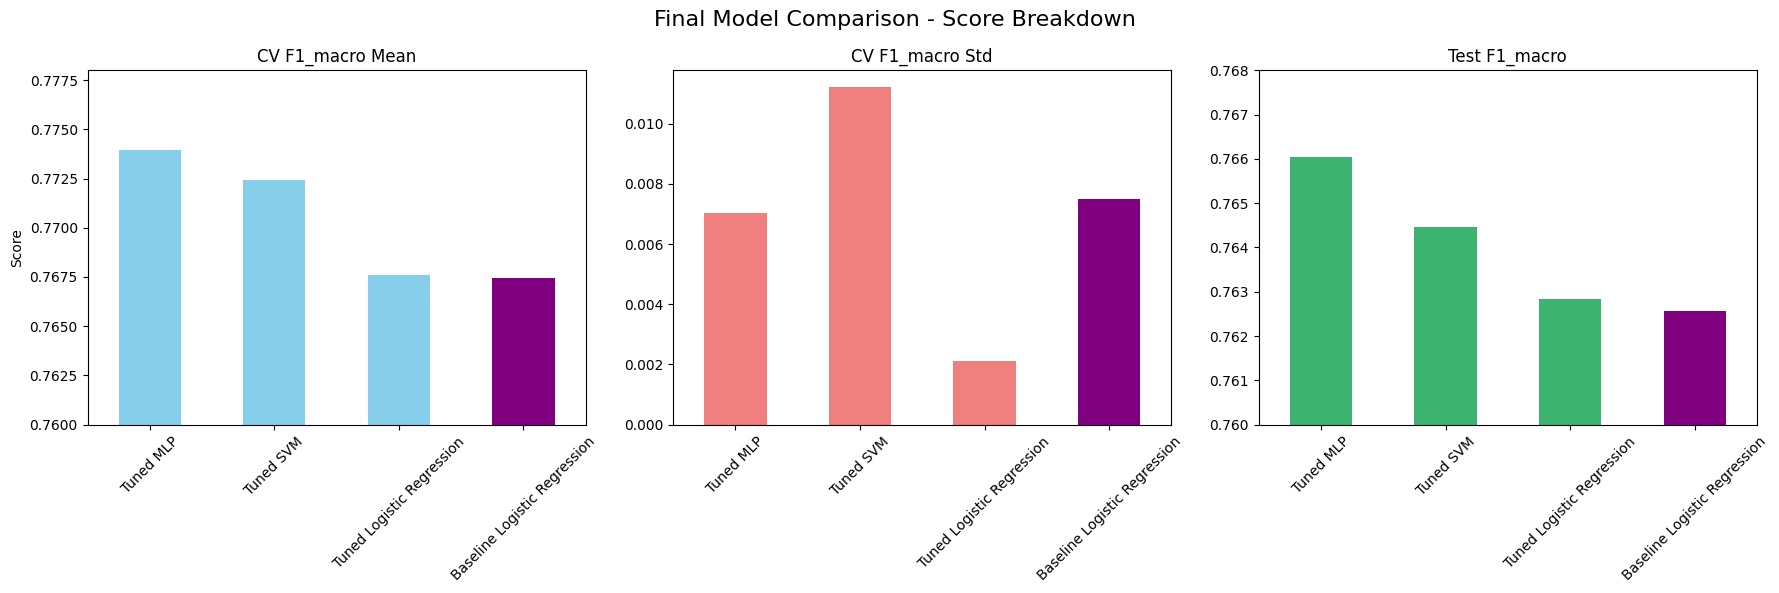

,CV F1_macro Mean,CV F1_macro Std,Test F1_macro
Tuned MLP,0.7740,0.0070,0.7661
Tuned SVM,0.7724,0.0112,0.7645
Tuned Logistic Regression,0.7676,0.0021,0.7628
Baseline Logistic Regression,0.7674,0.0075,0.7626


,CV F1_macro Mean (% Δ from Baseline),CV F1_macro Std (% Δ from Baseline),Test F1_macro (% Δ from Baseline)
Tuned MLP,0.85%,-6.22%,0.46%
Tuned SVM,0.65%,49.84%,0.25%
Tuned Logistic Regression,0.02%,-71.65%,0.03%


Best Hyperparameters per Model:


,C,max_iter,penalty,solver,gamma,activation,alpha,hidden_layer_sizes
Tuned Logistic Regression,100,1000,l2,liblinear,–,–,–,–
Tuned SVM,1,–,–,–,scale,–,–,–
Tuned MLP,–,–,–,–,–,relu,0.01,"(50,)"


In [ ]:
#---------------------------------------------------------------------------
# Part 8 / Final Model Comparison Summary 
#---------------------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Baseline scores 
# ---------------------------------------------------------------------------
logreg_f1_macro_mean = cv_scores.mean()
logreg_f1_macro_std = cv_scores.std()

final_results = {
    "Baseline Logistic Regression": [
        logreg_f1_macro_mean,
        logreg_f1_macro_std,
        test_f1_macro
    ],
    "Tuned Logistic Regression": [
        logreg_tuned_cv_mean,
        logreg_tuned_cv_std,
        logreg_tuned_test_f1
    ],
    "Tuned SVM": [
        svm_tuned_cv_mean,
        svm_tuned_cv_std,
        svm_tuned_test_f1
    ],
    "Tuned MLP": [
        mlp_tuned_cv_mean,
        mlp_tuned_cv_std,
        mlp_tuned_test_f1
    ]
}

# 1 Create DataFrame
# ---------------------------------------------------------------------------
final_df = pd.DataFrame.from_dict(
    final_results,
    orient="index",
    columns=["CV F1_macro Mean", "CV F1_macro Std", "Test F1_macro"]
).sort_values(by="Test F1_macro", ascending=False)

# 2 Bar Plots of All 3 Metrics
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Color logic

bar_colors = ["purple" if "Baseline" in idx else "skyblue" for idx in final_df.index]
final_df["CV F1_macro Mean"].plot.bar(ax=axes[0], color=bar_colors)
axes[0].set_title("CV F1_macro Mean")
axes[0].set_ylabel("Score")
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0.76, 0.778)

bar_colors = ["purple" if "Baseline" in idx else "lightcoral" for idx in final_df.index]
final_df["CV F1_macro Std"].plot.bar(ax=axes[1], color=bar_colors)
axes[1].set_title("CV F1_macro Std")
axes[1].tick_params(axis='x', rotation=45)

bar_colors = ["purple" if "Baseline" in idx else "mediumseagreen" for idx in final_df.index]
final_df["Test F1_macro"].plot.bar(ax=axes[2], color=bar_colors)
axes[2].set_title("Test F1_macro")
axes[2].tick_params(axis='x', rotation=45)
axes[2].set_ylim(0.76, 0.768)

plt.suptitle("Final Model Comparison - Score Breakdown", fontsize=16)
plt.tight_layout()
plt.show()

# 3 Table: highlight best per column 
# ---------------------------------------------------------------------------
def highlight_max_black(s):
    is_max = s == s.max()
    return ['background-color: lightgreen; color: black' if v else '' for v in is_max]

styled_final_df = final_df.style.apply(highlight_max_black, axis=0).format("{:.4f}")
display(styled_final_df)

# 4 % Improvement from Baseline
# ---------------------------------------------------------------------------
baseline = final_df.loc["Baseline Logistic Regression"]
improvement_df = final_df.copy()

for col in final_df.columns:
    improvement_df[col] = 100 * (final_df[col] - baseline[col]) / baseline[col]

improvement_df = improvement_df.drop("Baseline Logistic Regression")
improvement_df.columns = [col + " (% Δ from Baseline)" for col in improvement_df.columns]

display(improvement_df.style.format("{:.2f}%"))

# 5 Best Hyperparameters Table
# ---------------------------------------------------------------------------
best_params = {
    "Tuned Logistic Regression": grid_search_logreg.best_params_,
    "Tuned SVM": grid_search_svm.best_params_,
    "Tuned MLP": grid_search_mlp.best_params_,
}

best_params_df = pd.DataFrame(best_params).T.fillna("–")

print("Best Hyperparameters per Model:")
display(best_params_df)



In [ ]:
# ---------------------------------------------------------------------------
# APENDIX 1 : Extracts from attempting to further refine the parameters of MLP to their limits
# ---------------------------------------------------------------------------
#attempt with new expanded parameters

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

# 1 Define a grid 
# ---------------------------------------------------------------------------
param_grid = {
    'hidden_layer_sizes': [(10,), (25,), (50,), (75,), (50, 25)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
}

mlp = MLPClassifier(max_iter=2000, random_state=42)

# 2 Set up GridSearchCV
# ---------------------------------------------------------------------------
grid_search_mlp = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

# 3 Fit the model
# ---------------------------------------------------------------------------
grid_search_mlp.fit(X_train, y_train)

# 4 Output best configuration
# ---------------------------------------------------------------------------
print("Best parameters:", grid_search_mlp.best_params_)
print(f"Best CV F1_macro: {grid_search_mlp.best_score_:.4f}")

# 5 Evaluate on test set
# ---------------------------------------------------------------------------
best_mlp = grid_search_mlp.best_estimator_
best_mlp.fit(X_train, y_train)
y_test_pred = best_mlp.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f"Test F1_macro: {test_f1:.4f}")


Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,); total time=   2.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,); total time=   2.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,); total time=   2.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,); total time=   2.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,); total time=   2.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,); total time=   2.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,); total time=   3.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,); total time=   3.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,); total time=   2.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10,); total time=   2.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25,); total time=   5.9s
[C

In [ ]:
#funny enough the results were the same which means it's an even smaller scale. So smaller scale parameters were used and learning rate was added to see if it has an impact (default = 0.001)
# ---------------------------------------------------------------------------
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

# 1 Define a safe hyperparameter grid 
# ---------------------------------------------------------------------------
param_grid = {
    'hidden_layer_sizes': [(40,), (50,), (60,), (50, 10)],
    'activation': ['relu'],
    'alpha': [0.005, 0.01, 0.02],
    'learning_rate_init': [0.001, 0.0005, 0.0001]
}

mlp = MLPClassifier(max_iter=2000, random_state=42)

# 2 Set up GridSearchCV
# ---------------------------------------------------------------------------
grid_search_mlp = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

# 3 Fit the model
# ---------------------------------------------------------------------------
grid_search_mlp.fit(X_train, y_train)

# 4 Output best configuration
# ---------------------------------------------------------------------------
print("Best parameters:", grid_search_mlp.best_params_)
print(f"Best CV F1_macro: {grid_search_mlp.best_score_:.4f}")

# 5 Evaluate on test set
# ---------------------------------------------------------------------------
best_mlp = grid_search_mlp.best_estimator_
best_mlp.fit(X_train, y_train)
y_test_pred = best_mlp.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f"Test F1_macro: {test_f1:.4f}")


Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END activation=relu, alpha=0.005, hidden_layer_sizes=(40,), learning_rate_init=0.001; total time=   7.5s
[CV] END activation=relu, alpha=0.005, hidden_layer_sizes=(40,), learning_rate_init=0.001; total time=   8.4s
[CV] END activation=relu, alpha=0.005, hidden_layer_sizes=(40,), learning_rate_init=0.001; total time=   9.2s
[CV] END activation=relu, alpha=0.005, hidden_layer_sizes=(40,), learning_rate_init=0.001; total time=   9.4s
[CV] END activation=relu, alpha=0.005, hidden_layer_sizes=(40,), learning_rate_init=0.001; total time=  10.0s
[CV] END activation=relu, alpha=0.005, hidden_layer_sizes=(40,), learning_rate_init=0.001; total time=  10.3s
[CV] END activation=relu, alpha=0.005, hidden_layer_sizes=(40,), learning_rate_init=0.001; total time=  10.8s
[CV] END activation=relu, alpha=0.005, hidden_layer_sizes=(40,), learning_rate_init=0.001; total time=  11.2s
[CV] END activation=relu, alpha=0.005, hidden_layer_sizes

In [ ]:
#further refinement
# ---------------------------------------------------------------------------
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

# 1 Define a safe hyperparameter grid 
# ---------------------------------------------------------------------------
param_grid = {
    'hidden_layer_sizes': [(45,), (50,), (55,), (60,), (60, 10)],
    'activation': ['relu'],
    'alpha': [0.003, 0.005, 0.007],
    'learning_rate_init': [0.0003, 0.0005, 0.0007]
}

mlp = MLPClassifier(max_iter=2000, random_state=42)

# 2 Set up GridSearchCV
# ---------------------------------------------------------------------------
grid_search_mlp = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

# 3 Fit the model
# ---------------------------------------------------------------------------
grid_search_mlp.fit(X_train, y_train)

# 4 Output best configuration
# ---------------------------------------------------------------------------
print("Best parameters:", grid_search_mlp.best_params_)
print(f"Best CV F1_macro: {grid_search_mlp.best_score_:.4f}")

# 5 Evaluate on test set
# ---------------------------------------------------------------------------
best_mlp = grid_search_mlp.best_estimator_
best_mlp.fit(X_train, y_train)
y_test_pred = best_mlp.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f"Test F1_macro: {test_f1:.4f}")


Fitting 10 folds for each of 45 candidates, totalling 450 fits
[CV] END activation=relu, alpha=0.003, hidden_layer_sizes=(45,), learning_rate_init=0.0003; total time=   5.6s
[CV] END activation=relu, alpha=0.003, hidden_layer_sizes=(45,), learning_rate_init=0.0003; total time=   8.0s
[CV] END activation=relu, alpha=0.003, hidden_layer_sizes=(45,), learning_rate_init=0.0003; total time=  10.9s
[CV] END activation=relu, alpha=0.003, hidden_layer_sizes=(45,), learning_rate_init=0.0003; total time=  12.2s
[CV] END activation=relu, alpha=0.003, hidden_layer_sizes=(45,), learning_rate_init=0.0003; total time=   4.9s
[CV] END activation=relu, alpha=0.003, hidden_layer_sizes=(45,), learning_rate_init=0.0003; total time=  14.9s
[CV] END activation=relu, alpha=0.003, hidden_layer_sizes=(45,), learning_rate_init=0.0003; total time=  16.7s
[CV] END activation=relu, alpha=0.003, hidden_layer_sizes=(45,), learning_rate_init=0.0003; total time=  17.6s
[CV] END activation=relu, alpha=0.003, hidden_lay

In [ ]:
#EXPERIMENTAL Bayesian approach
# ---------------------------------------------------------------------------
import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
import numpy as np

# 1 Define layer options as strings for compatibility
# ---------------------------------------------------------------------------
layer_options = ["50", "55", "60", "50-10", "55-10"]

# 2 Objective function for Optuna
# ---------------------------------------------------------------------------
def objective(trial):
    # Decode string to tuple!!!
    raw_choice = trial.suggest_categorical("hidden_layer_sizes", layer_options)
    hidden_layer_sizes = tuple(int(x) for x in raw_choice.split("-"))

    alpha = trial.suggest_float("alpha", 0.0001, 0.02, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 0.0001, 0.01, log=True)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])

    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        activation=activation,
        max_iter=2000,
        random_state=42
    )

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    return np.mean(scores)

# 3 Create and run the study
# ---------------------------------------------------------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=900) 

# 4 Print best results
# ---------------------------------------------------------------------------
print("Best trial:")
print(f"  Value: {study.best_value:.4f}")
print("  Params:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

# 5 Train best model on full train set and evaluate on test set
# ---------------------------------------------------------------------------
best_params = study.best_params
final_hidden_layer_sizes = tuple(int(x) for x in best_params["hidden_layer_sizes"].split("-"))

best_mlp = MLPClassifier(
    hidden_layer_sizes=final_hidden_layer_sizes,
    alpha=best_params["alpha"],
    learning_rate_init=best_params["learning_rate_init"],
    activation=best_params["activation"],
    max_iter=2000,
    random_state=42
)

best_mlp.fit(X_train, y_train)
y_test_pred = best_mlp.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f"Test F1_macro Score: {test_f1:.4f}")



[I 2025-07-30 00:13:06,197] A new study created in memory with name: no-name-bcbd8f2f-0102-49df-afd7-1493199ee534


[I 2025-07-30 00:13:19,320] Trial 0 finished with value: 0.7691460789867655 and parameters: {'hidden_layer_sizes': '50-10', 'alpha': 0.00038356749472689337, 'learning_rate_init': 0.002803497458476035, 'activation': 'relu'}. Best is trial 0 with value: 0.7691460789867655.
[I 2025-07-30 00:13:29,262] Trial 1 finished with value: 0.771811729404325 and parameters: {'hidden_layer_sizes': '55', 'alpha': 0.00030309690896504433, 'learning_rate_init': 0.004819168865043934, 'activation': 'relu'}. Best is trial 1 with value: 0.771811729404325.
[I 2025-07-30 00:13:44,597] Trial 2 finished with value: 0.7733623203903629 and parameters: {'hidden_layer_sizes': '50', 'alpha': 0.0001630107460140337, 'learning_rate_init': 0.0011347619715641934, 'activation': 'tanh'}. Best is trial 2 with value: 0.7733623203903629.
[I 2025-07-30 00:13:57,794] Trial 3 finished with value: 0.77460669320317 and parameters: {'hidden_layer_sizes': '50', 'alpha': 0.0007169692777733196, 'learning_rate_init': 0.00081118259389794

Best trial:
  Value: 0.7748
  Params:
    hidden_layer_sizes: 50
    alpha: 0.003263771286079597
    learning_rate_init: 0.0006240355876401968
    activation: relu
Test F1_macro Score: 0.7663


In [ ]:
# Another Attempt
# ---------------------------------------------------------------------------
import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
import numpy as np

# 1 Hidden layer choices as strings for compatibility
# ---------------------------------------------------------------------------
layer_options = ["40", "45", "50", "55", "60", "50-10", "55-10", "60-10"]

# 2 Objective function
# ---------------------------------------------------------------------------
def objective(trial):
    raw_choice = trial.suggest_categorical("hidden_layer_sizes", layer_options)
    hidden_layer_sizes = tuple(int(x) for x in raw_choice.split("-"))

    alpha = trial.suggest_float("alpha", 0.002, 0.01, step=0.001)
    learning_rate_init = trial.suggest_float("learning_rate_init", 0.0001, 0.0015, step=0.0002)
    activation = trial.suggest_categorical("activation", ["relu"])

    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        activation=activation,
        max_iter=2000,
        random_state=42
    )

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    return np.mean(scores)

# 3 Run Optuna optimization
# ---------------------------------------------------------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=300)  

# 4 Display best trial
# ---------------------------------------------------------------------------
print("Best trial:")
print(f"  Value: {study.best_value:.4f}")
print("  Params:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

# 5 Train best MLP on full training set
# ---------------------------------------------------------------------------
best_params = study.best_params
final_hidden_layer_sizes = tuple(int(x) for x in best_params["hidden_layer_sizes"].split("-"))

best_mlp = MLPClassifier(
    hidden_layer_sizes=final_hidden_layer_sizes,
    alpha=best_params["alpha"],
    learning_rate_init=best_params["learning_rate_init"],
    activation=best_params["activation"],
    max_iter=2000,
    random_state=42
)

best_mlp.fit(X_train, y_train)
y_test_pred = best_mlp.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f"Test F1_macro Score: {test_f1:.4f}")


[I 2025-07-30 00:32:41,874] A new study created in memory with name: no-name-674ffdff-ad1a-4161-a5fa-426ad84c210f
[I 2025-07-30 00:33:02,380] Trial 0 finished with value: 0.7728664789349928 and parameters: {'hidden_layer_sizes': '50', 'alpha': 0.009000000000000001, 'learning_rate_init': 0.00030000000000000003, 'activation': 'relu'}. Best is trial 0 with value: 0.7728664789349928.
[I 2025-07-30 00:33:21,616] Trial 1 finished with value: 0.7718401916401939 and parameters: {'hidden_layer_sizes': '45', 'alpha': 0.005, 'learning_rate_init': 0.0007000000000000001, 'activation': 'relu'}. Best is trial 0 with value: 0.7728664789349928.
[I 2025-07-30 00:33:34,193] Trial 2 finished with value: 0.7704014643597175 and parameters: {'hidden_layer_sizes': '60-10', 'alpha': 0.009000000000000001, 'learning_rate_init': 0.0015, 'activation': 'relu'}. Best is trial 0 with value: 0.7728664789349928.
[I 2025-07-30 00:33:45,736] Trial 3 finished with value: 0.7720758888192324 and parameters: {'hidden_layer_s

Best trial:
  Value: 0.7738
  Params:
    hidden_layer_sizes: 60-10
    alpha: 0.008
    learning_rate_init: 0.00030000000000000003
    activation: relu
Test F1_macro Score: 0.7648


In [ ]:
# Final Bayesian Optimization (refined search space)
# ---------------------------------------------------------------------------
import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
import numpy as np

# 1 Define hidden layer options near the previous top-performing ones
# ---------------------------------------------------------------------------
layer_options = ["45", "50", "55", "50-10", "60-10"]

# 2 Objective function for Optuna
# ---------------------------------------------------------------------------
def objective(trial):
    # Parse string to tuple dont forget
    raw_choice = trial.suggest_categorical("hidden_layer_sizes", layer_options)
    hidden_layer_sizes = tuple(int(x) for x in raw_choice.split("-"))

    # Fine-grained parameter ranges around Trial B's best result
    alpha = trial.suggest_float("alpha", 0.002, 0.005, step=0.0005)
    learning_rate_init = trial.suggest_float("learning_rate_init", 0.0005, 0.0007, step=0.00005)
    activation = trial.suggest_categorical("activation", ["relu"])  # Fixed to best

    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        activation=activation,
        max_iter=2000,
        random_state=42,
    )

    # Cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    return np.mean(scores)

# 3 Run the Optuna optimization
# ---------------------------------------------------------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=300)  # 5 minutes

# 4 Display best trial
# ---------------------------------------------------------------------------
print("Best trial:")
print(f"  Value: {study.best_value:.4f}")
print("  Params:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

# 5 Fit best model on full training set and evaluate on test set
# ---------------------------------------------------------------------------
best_params = study.best_params
final_hidden_layer_sizes = tuple(int(x) for x in best_params["hidden_layer_sizes"].split("-"))

best_mlp = MLPClassifier(
    hidden_layer_sizes=final_hidden_layer_sizes,
    alpha=best_params["alpha"],
    learning_rate_init=best_params["learning_rate_init"],
    activation=best_params["activation"],
    max_iter=2000,
    random_state=42,
)

best_mlp.fit(X_train, y_train)
y_test_pred = best_mlp.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f"Test F1_macro Score: {test_f1:.4f}")


[I 2025-07-30 00:51:10,753] A new study created in memory with name: no-name-f95c4264-c805-4846-bbc8-a9705de10dba
[I 2025-07-30 00:51:30,986] Trial 0 finished with value: 0.7723248334715791 and parameters: {'hidden_layer_sizes': '45', 'alpha': 0.0025, 'learning_rate_init': 0.00065, 'activation': 'relu'}. Best is trial 0 with value: 0.7723248334715791.
[I 2025-07-30 00:51:50,285] Trial 1 finished with value: 0.7724714770747981 and parameters: {'hidden_layer_sizes': '60-10', 'alpha': 0.002, 'learning_rate_init': 0.00065, 'activation': 'relu'}. Best is trial 1 with value: 0.7724714770747981.
[I 2025-07-30 00:52:09,394] Trial 2 finished with value: 0.7721057145853316 and parameters: {'hidden_layer_sizes': '45', 'alpha': 0.003, 'learning_rate_init': 0.00055, 'activation': 'relu'}. Best is trial 1 with value: 0.7724714770747981.
[I 2025-07-30 00:52:30,002] Trial 3 finished with value: 0.7717626580101115 and parameters: {'hidden_layer_sizes': '50-10', 'alpha': 0.0025, 'learning_rate_init': 0.

Best trial:
  Value: 0.7739
  Params:
    hidden_layer_sizes: 55
    alpha: 0.004
    learning_rate_init: 0.0007
    activation: relu
Test F1_macro Score: 0.7685
